### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

# Regression Lineal en los parametros

Este notebook es un ejemplo regresion no lineal, en particular regresión lineal en los parámetros usando bases de funciones.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# dataset mauna loa
from sklearn.datasets import fetch_mldata 

configuración plots

In [2]:
# estilo por defecto de seaborn
sns.set()  
# contexto notebook  y escala de fuente
sns.set_context('notebook', font_scale=1.6)
# estilo, fondo blanco con 'ticks' en los ejes
sns.set_style('ticks')
# tamaño por defecto de las figuras
plt.rcParams['figure.figsize'] = (10, 5)

## Datasets opcionales:
Pueden jugar con los siguientes [datos](http://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) , (nonlinear regression datasets)

In [3]:
# 1 para gauss2.csv de la página mostrada, 2 para mauna-loa
dataset_select = 1 

if dataset_select == 1:
    data = np.loadtxt('../datos/gauss2.csv')
    x = data[:, 1]
    y = data[:, 0]
elif dataset_select == 2:
    data = fetch_mldata('mauna-loa-atmospheric-co2').data
    x = data[:, 1]
    y = data[:, 0]

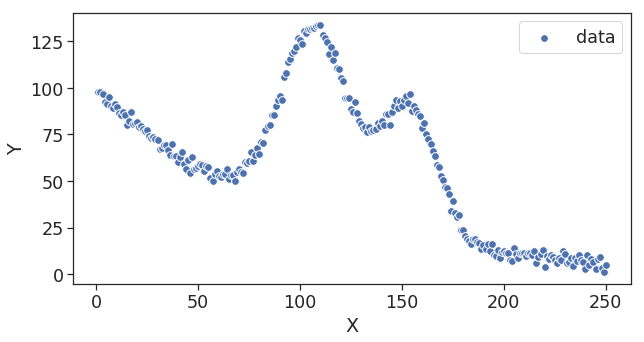

In [4]:
plt.scatter(x, y, s=60, label='data', edgecolor='w')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y');

# Regresión lineal-en-los-parámetros

__Modelo:__ $$y=w \Phi (x) + \epsilon \quad, \epsilon \sim \mathcal{N}(0, \sigma_n^2)$$



__Función objetivo:__ $$ J \propto  \frac{1}{2}\sum_{i=1}^{N} \left( y_i - w \Phi(x_i) \right)^2 + \rho ||w||^2$$



__Parámetros óptimos:__ $$w = \left[ \Phi(x)^T \Phi(x) + \rho I \right]^{-1} \Phi(x)^T Y $$



_Nota implementación_: multiplicación de matrices de forma fácil en python
` A @ B ==A.dot(B) = np.dot(A, B)`


In [5]:
def basis_reg(func, x, y, rho=0.1, prop=0.7, x_reg=None, label='', mode='pred', **kwargs):
    """
    Regresion en base de funciones.
    Parámetros:
    func : Función de python que recibe un array de 1 x n y retorna la matriz de diseño Phi. 
    x : Array de 1 x n con los regresores.
    y : Array de 1 x n con las observaciones.
    rho : Coeficiente de regularización.
    x_reg : Puntos en donde se evalua la prediccion.
    mode : Modo de la regresión 'pred' para predicción 'inter' para interpolación.
    Para predicción los puntos de entrenamiento se obtienen tomando
    la proporción 'prop' de los primeros puntos, dejando los otros para test.
    Para interpolación se toman al azar la fracción 'prop' de los datos para
    entrenamiento, y el resto para test.
    kwargs  :  diccionario con los argumentos de la función 'func'.
    """
    # numero de elementos del conjunto de entrenamiento
    p = int(prop * len(x))
    if mode=='pred':
        phi_x = func(x[:p], **kwargs)
        w = np.linalg.inv(phi_x.T @ phi_x + rho * np.eye(phi_x.shape[1])) @ phi_x.T @ y[:p]
        print('Pesos ', label, w)

        if x_reg is None:
            x_reg = x
        # plot
        plt.scatter(x[:p], y[:p], s=60, c='k', label='train', edgecolor='w', alpha=0.8, zorder=1)
        plt.scatter(x[p:], y[p:], s=50, c='r', label='test', edgecolor='w', alpha=0.8, zorder=2)
        plt.title('Predicción ' + label)
    
    elif mode=='inter':
        train_points = np.sort(np.random.choice(len(x), p, replace=False))
        phi_x = func(x[train_points], **kwargs)
        w = np.linalg.inv(phi_x.T @ phi_x + rho * np.eye(phi_x.shape[1])) @ phi_x.T @ y[train_points]
        print('Pesos ', label, w)
        
        if x_reg is None:
            x_reg = x
    
        mask = np.ones_like(x).astype(bool)
        mask[train_points] = False
        plt.scatter(x[mask], y[mask], s=50, label='test', c='r', edgecolor='w', alpha=0.8, zorder=2)
        plt.scatter(x[train_points], y[train_points], c='k', s=60, label='train', edgecolor='w', alpha=0.8, zorder=1)
        plt.title('Interpolación ' + label)
    else:
        print("Solo se aceptan modos 'inter o 'pred'")
        
    plt.plot(x_reg, w @ func(x_reg, **kwargs).T, label=label, lw=3, zorder=3, linestyle='--')
    plt.legend()
    plt.tight_layout()

## Base polinomial

In [6]:
def poly(x, deg=1):
    """
    x: Array de inputs
    d: Grado del polinomio
    """
    # contenedor
    phi_x = np.ones((len(x), deg+1)) 
    # llenar contenedor
    for power in range(deg + 1):
        phi_x[:, power] = x ** power
    return phi_x

__ajuste y predicción__

Pesos  Poly order 10 [ 1.11563832e+02 -8.72658143e+00  9.43401717e-01 -4.56203943e-02
  1.12045803e-03 -1.56989532e-05  1.33969343e-07 -7.11228898e-10
  2.29734329e-12 -4.13625588e-15  3.18415871e-18]


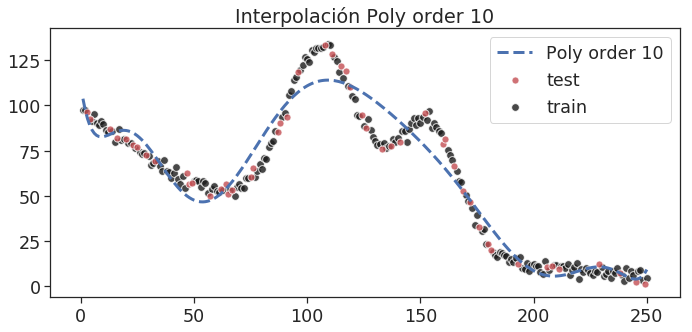

In [7]:
kwargs = {'deg':10} # argumentos base polinomial
rho = 0.1  # regularizacion
p = 0.8  # proporcion conjunto de entrenamiento

# regression
label = 'Poly order ' + str(kwargs['deg'])

basis_reg(poly,
          x,
          y,
          rho=rho,
          prop=p,
          label=label,
          mode='inter',
          **kwargs)

## Base sinusoidal

In [8]:
def cosine(x, deg=1, T=2):
    """
    x : Array inputs
    d : Grado
    T : Periodo
    """
    phi_x = np.ones((len(x), deg+1)) # container
    for d in range(1, deg + 1):
        phi_x[:, d] = np.cos(d * 2 * np.pi / deg / T * x)
    return phi_x

Pesos  coseno orden 50 periodo 30 [ 30.1800754   27.88365068  21.34858916  11.78001044   1.38594254
  -6.9888788  -10.9172636   -9.61838391  -4.48038013   1.6415732
   5.99841787   7.36024644   6.3400148    4.52575638   3.19785676
   2.61948899   2.29297363   1.72973886   0.9351174    0.22399164
  -0.29142231  -0.88860226  -1.84201794  -2.88185669  -3.17871836
  -2.03111066   0.33781135   2.70683591   3.72187122   2.98541885
   1.34888698   0.08977479  -0.25474502  -0.24464838  -0.72094803
  -1.68633223  -2.14595676  -1.20321312   0.7183801    1.9901104
   1.37560111  -0.48623457  -1.51982433  -0.46500297   1.42655211
   1.56219909  -0.65673685  -2.23502961   0.03241027   3.3541485
  -2.28329864]


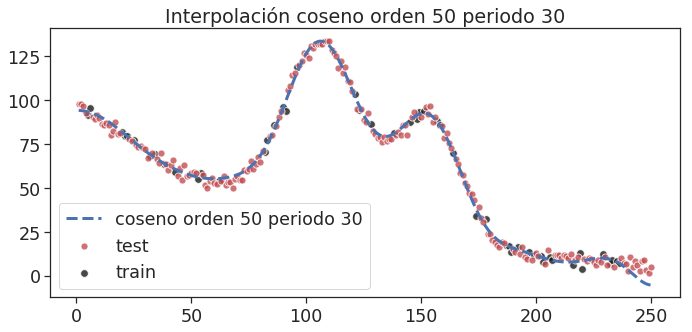

In [9]:
np.random.seed(123)

# argumentos base de funciones
kwargs = {'deg': 50, 'T': 30}
rho = 0.01

# proporcion conjunto de entrenamiento
prop = 0.2

label = 'coseno orden ' + str(kwargs['deg']) + ' periodo ' + str(kwargs['T'])
basis_reg(cosine, x, y, rho=rho, prop=prop, label=label, mode='inter', **kwargs)

## Base escalón (step)

In [10]:
def step(x, k=10):
    """
    x : Array de input
    k : Número de particiones o escalones
    """
    # contenedor
    phi_x = np.ones((len(x), k+1))
    # tamaño de cada escalón
    step = (x.max() - x.min()) / k
    # llenar contenedor
    for region in range(1, k + 1):
        # obtiene binario y pasa a integer (0, 1)
        phi_x[:, region] = ((x > x.min()) & (x < x.min() + region * step)).astype(int)
    return phi_x

Pesos  N° escalones 20 [ 44.22461151  10.53208403  11.28243222   4.13101816   6.17944362
 -10.02933324 -23.97733307 -41.95444718   2.43900351  27.49523246
  18.72520003 -14.13582248  12.93025545  33.47850207  25.13733286
  12.14556731  -2.02353528  -0.34825226   2.52393746   2.52393746
 -37.62928738]


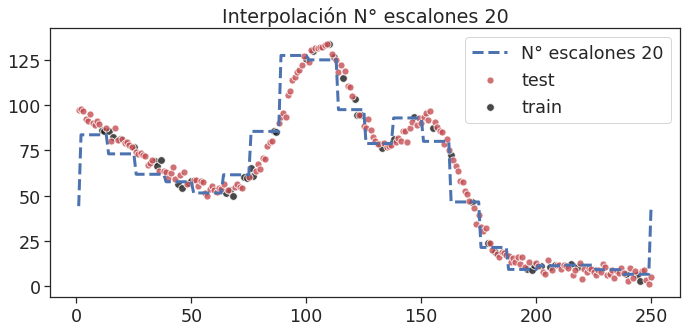

In [11]:
# argumentos base de funciones
kwargs = {'k': 20}  

# regularizacion
rho = 0.01

# proporcion entrenamiento
prop = 0.2

# optimal weights
label = 'N° escalones ' + str(kwargs['k'])

basis_reg(step, x, y, rho=rho, prop=prop, label=label, mode='inter', **kwargs)

## Cubic Splines

Text(0.5, 1.0, 'Cubic spline interpolacion')

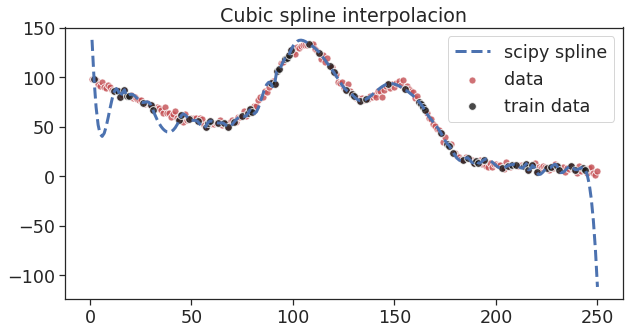

In [12]:
from scipy.interpolate import CubicSpline

# proporcion entrenamiento
prop = 0.3

# seleccionar de forma aleatoria puntos
train_points = np.sort(np.random.choice(len(x), int(len(x) * prop), replace=False))

# Realizar interpolacion
cs = CubicSpline(x[train_points], y[train_points])
x_reg = x

plt.scatter(x, y, c='r', s=50, alpha=.8, label='data', edgecolor='w')
plt.scatter(x[train_points], y[train_points], c='k', s=60, label='train data', edgecolor='w', alpha=0.8)
plt.plot(x_reg, cs(x_reg), label='scipy spline', ls='--', lw=3)
plt.legend()
plt.title('Cubic spline interpolacion')